In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melbourne-housing-snapshot/melb_data.csv


# Introduction

  The purporse of this notebook is to implement an end to end machine learning project in Kaggle where I use what I learned in Chapter 2 of the book. I will consult the book from time to time to see what I can learn, but I will do it alone for the most part. 


In [49]:
melb_data = pd.read_csv('/kaggle/input/melbourne-housing-snapshot/melb_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

<Axes: >

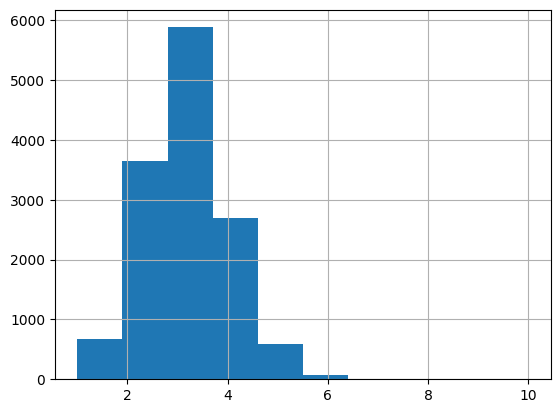

In [50]:
melb_data.head
melb_data.columns

# We would like to predict the Price of a house
melb_data.info()
melb_data.Method.value_counts()
melb_data.Suburb.value_counts() 
cat_features = ['Method','Suburb','SellerG']
melb_data.SellerG.value_counts()
time_features = ['Date']
melb_data.Date.value_counts()
melb_data.columns
melb_data.Rooms.hist()

In [51]:
melb_data.describe()
from sklearn.preprocessing import FunctionTransformer

# The first thing that I will do is to split my data into a test and train set
# To preserve the distribution in both sets, I will use a Stratified Shuffle Split
# We use a stratified shuffle split, due to the fact that we don't have a large dataset
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn

splitter = StratifiedShuffleSplit(n_splits=10, random_state=42, test_size = 0.2)
features = list(melb_data.columns)
features.remove('Price')
print(features)

X = melb_data[features + ['Price']].copy()
# Upper bound included, lower bound excluded
y = pd.cut(melb_data['Rooms'], bins=[0,3,6,12],labels=['low','mid','high'])
X['Rooms'] = pd.cut(X['Rooms'], bins=[0,3,6,12],labels=['low','mid','high'])

def room_to_cat(column):
    new_col = pd.cut(X['Rooms'], bins=[-np.inf,3,6,np.inf],labels=['low','mid','high'])
    return new_col

room_cat_transformer = FunctionTransformer(room_to_cat,validate=False)

strat_splits = []
for train, test in splitter.split(X=X,y=y):
    strat_train_set =   X.loc[train]
    strat_test_set = X.loc[test]
    strat_splits.append([strat_train_set,strat_test_set])

strat_splits_train, strat_splits_test = strat_splits[0] 
strat_splits_train.info()
strat_splits_train_copy = strat_splits_train.copy(deep=True)

['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']
<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   SellerG        10864 non-null  object  
 6   Date           10864 non-null  object  
 7   Distance       10864 non-null  float64 
 8   Postcode       10864 non-null  float64 
 9   Bedroom2       10864 non-null  float64 
 10  Bathroom       10864 non-null  float64 
 11  Car            10810 non-null  float64 
 12  Landsize       10864 n

Ok now we will continue with cleaning our data and making useful features, let us start with our Rooms, based on my intuition, I suspect that this is something that we can create a categorical variable from, this is based on the assumption that
1. There are ranges of rooms that people will need, so Kitchen, LR, BR, 1br is the most basic, 2 br  i.e. 5 rooms shows that it is needed, 6 rooms can also be arguable needed, above 6 is extremely rare and may be heading towards oppulence and we can consider this all as a single category. If you are a bachelor or single, you may only have 3 rooms, kitchen, br, bathroom,

2. So I will make the categories, 0-3 single, 4-6 family, above oppulence

In [52]:
rooms = y
print(rooms.value_counts(dropna=False))

Rooms
low     10210
mid      3351
high       19
Name: count, dtype: int64


Let us now create our features and clean our data.
First let us start with the address.

So as I saw before I have streat names, I think I can probalbly match the strings and 
get rid of the numbers and then use the mean of each street to get the value for imputation
A key assumption here is that melbourne does not have streets with the same name


In [53]:
import re
from sklearn.preprocessing import FunctionTransformer

# match any decimal digit and any single letter modifier for cases like 88a Turner Street
# + matches at least one, ? matches at most one * matches as many *? 
# matches as few as possivle 
# ?+ is greedy, which we need in this case
def get_street(address):
    # Compile regex: Best prcatice to avoid recompilation overhead
    re_pattern = re.compile(r'[\d]+[a-zA-Z]?+')
    result = re.split(re_pattern,address,maxsplit=1)
    street_name = result[1]
    return street_name

def add_address_group(df):
    addr_grp = df['Address'].map(get_street)
    df = df.copy()
    df['AddressGroup'] = addr_grp
    return df


add_address_group_tf = FunctionTransformer(add_address_group, validate=False)

strat_splits_train['AddressGroup'] = strat_splits_train.Address.map(get_street)


# Drop this feature, so that i know that I don't have to deal with it later
# I assume that realtors sell a variety of houses
strat_splits_train.SellerG.value_counts()



SellerG
Nelson           1238
Jellis           1068
hockingstuart     927
Barry             826
Ray               562
                 ... 
Joe                 1
Upper               1
Wood                1
Appleby             1
iProperty           1
Name: count, Length: 240, dtype: int64

In [54]:
strat_splits_train.drop(labels='SellerG', axis=1, inplace=True)



WE 

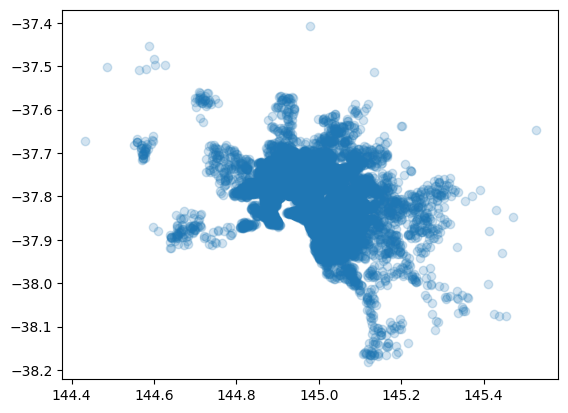

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


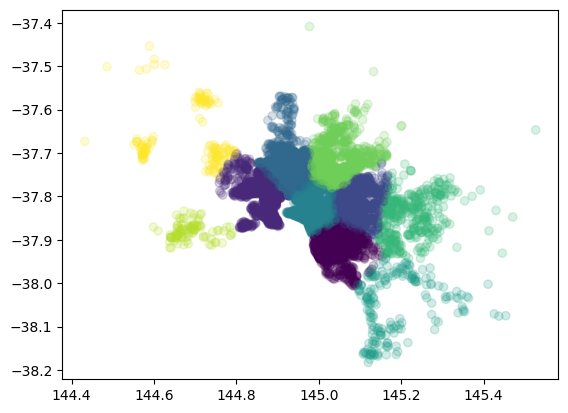

In [55]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.scatter('Longtitude','Lattitude', data=strat_splits_train, alpha = 0.2)
plt.show()


# The Kmeans clustering approach may not be suited to this method, but for now we will use it and 
# improve the model as we learn more about clusterign algorithms.
# We use 9 clusters as what we can roughly identify from the scatter plot.
kmeans_cluster = KMeans(n_clusters=10, random_state=42)
kmeans_cluster.fit(strat_splits_train[['Longtitude','Lattitude']])

# Let us try and visualize the clusters that were discoverd
plt.scatter('Longtitude','Lattitude', c=kmeans_cluster.labels_, data=strat_splits_train, alpha = 0.2)
strat_splits_train['HouseCluster'] = kmeans_cluster.labels_

In [56]:
strat_splits_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Date           10864 non-null  object  
 6   Distance       10864 non-null  float64 
 7   Postcode       10864 non-null  float64 
 8   Bedroom2       10864 non-null  float64 
 9   Bathroom       10864 non-null  float64 
 10  Car            10810 non-null  float64 
 11  Landsize       10864 non-null  float64 
 12  BuildingArea   5713 non-null   float64 
 13  YearBuilt      6580 non-null   float64 
 14  CouncilArea    9782 non-null   object  
 15  Lattitude      10864 non-null  float64 
 16  Longtitude     10864 non-null  float64 
 17  Regionname     10864 non-null  obj

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Date           10864 non-null  object  
 6   Distance       10864 non-null  float64 
 7   Postcode       10864 non-null  float64 
 8   Bedroom2       10864 non-null  float64 
 9   Bathroom       10864 non-null  category
 10  Car            10810 non-null  float64 
 11  Landsize       10864 non-null  float64 
 12  BuildingArea   5713 non-null   float64 
 13  YearBuilt      6580 non-null   float64 
 14  CouncilArea    9782 non-null   object  
 15  Lattitude      10864 non-null  float64 
 16  Longtitude     10864 non-null  float64 
 17  Regionname     10864 non-null  obj

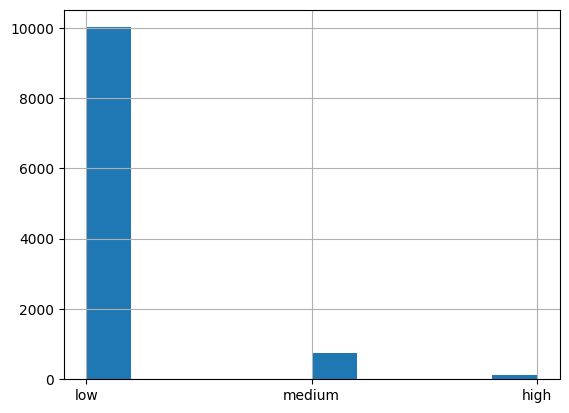

In [57]:
ordinal_features = ['Suburb','AddressGroup','Postcode']
one_hot = ['Rooms','Type','Method','Regionname','Bathroom']
boolean = ['Bedroom2']
numeric =['Distance','Landsize','Propertycount']
# pay attention, there are those that have 0 bathrooms and the lower bound is excluded
strat_splits_train['Bathroom'] = pd.cut(x=strat_splits_train['Bathroom'], bins =[-np.inf,2,3,np.inf], labels=['low','medium','high'])

def bath_to_cat(x):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]

    # labels=False → integer codes 0,1,2 instead of strings
    out = pd.cut(
        x,
        bins=[-np.inf, 2, 3, np.inf],
        labels=False         # 0 = low, 1 = medium, 2 = high
    )
    return out.to_frame()    # keep 2‑D shape


bath_transformer = FunctionTransformer(func=bath_to_cat,validate=False)
strat_splits_train['Bathroom'].hist()
strat_splits_train.info()


In [58]:
# impute missign values for car based on longitude and latitude
from sklearn.impute import KNNImputer

car_geo_col = ['Longtitude','Lattitude','Car']
car_geo = strat_splits_train[car_geo_col]

car_imputer = KNNImputer(n_neighbors=4)

imputed_geo_car = car_imputer.fit_transform(car_geo)
strat_splits_train[car_geo_col] = imputed_geo_car 

strat_splits_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Date           10864 non-null  object  
 6   Distance       10864 non-null  float64 
 7   Postcode       10864 non-null  float64 
 8   Bedroom2       10864 non-null  float64 
 9   Bathroom       10864 non-null  category
 10  Car            10864 non-null  float64 
 11  Landsize       10864 non-null  float64 
 12  BuildingArea   5713 non-null   float64 
 13  YearBuilt      6580 non-null   float64 
 14  CouncilArea    9782 non-null   object  
 15  Lattitude      10864 non-null  float64 
 16  Longtitude     10864 non-null  float64 
 17  Regionname     10864 non-null  obj

In [59]:
# We cannot correct for this data, so we will just drop the column, in the future we can look to implement more complex imputation strategies
# Or to correst the data based on public information
strat_splits_train.drop(labels='CouncilArea',axis=1,inplace=True)
strat_splits_train.drop(labels='BuildingArea',axis=1,inplace=True)
strat_splits_train.info()




<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Date           10864 non-null  object  
 6   Distance       10864 non-null  float64 
 7   Postcode       10864 non-null  float64 
 8   Bedroom2       10864 non-null  float64 
 9   Bathroom       10864 non-null  category
 10  Car            10864 non-null  float64 
 11  Landsize       10864 non-null  float64 
 12  YearBuilt      6580 non-null   float64 
 13  Lattitude      10864 non-null  float64 
 14  Longtitude     10864 non-null  float64 
 15  Regionname     10864 non-null  object  
 16  Propertycount  10864 non-null  float64 
 17  Price          10864 non-null  flo

In [60]:
# I really can't estimate the year that a house was built, so I will just drop it

strat_splits_train.drop('YearBuilt', axis=1,inplace=True)
strat_splits_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Date           10864 non-null  object  
 6   Distance       10864 non-null  float64 
 7   Postcode       10864 non-null  float64 
 8   Bedroom2       10864 non-null  float64 
 9   Bathroom       10864 non-null  category
 10  Car            10864 non-null  float64 
 11  Landsize       10864 non-null  float64 
 12  Lattitude      10864 non-null  float64 
 13  Longtitude     10864 non-null  float64 
 14  Regionname     10864 non-null  object  
 15  Propertycount  10864 non-null  float64 
 16  Price          10864 non-null  float64 
 17  AddressGroup   10864 non-null  obj

In [61]:
# As all valeus are in one year, we assume that price will be minimally affected by date
strat_splits_train.drop(labels='Date', axis=1, inplace=True)
strat_splits_train.info()
strat_splits_train.loc[3303]

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  object  
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Distance       10864 non-null  float64 
 6   Postcode       10864 non-null  float64 
 7   Bedroom2       10864 non-null  float64 
 8   Bathroom       10864 non-null  category
 9   Car            10864 non-null  float64 
 10  Landsize       10864 non-null  float64 
 11  Lattitude      10864 non-null  float64 
 12  Longtitude     10864 non-null  float64 
 13  Regionname     10864 non-null  object  
 14  Propertycount  10864 non-null  float64 
 15  Price          10864 non-null  float64 
 16  AddressGroup   10864 non-null  object  
 17  HouseCluster   10864 non-null  int

Suburb                Heidelberg West
Address                   19 Derna St
Rooms                             low
Type                                h
Method                              S
Distance                          9.4
Postcode                       3081.0
Bedroom2                          2.0
Bathroom                          low
Car                               0.0
Landsize                        627.0
Lattitude                    -37.7469
Longtitude                   145.0399
Regionname       Eastern Metropolitan
Propertycount                  2674.0
Price                        752000.0
AddressGroup                 Derna St
HouseCluster                        7
Name: 3303, dtype: object

In [62]:
melb_data.loc[3303]

Suburb                Heidelberg West
Address                   19 Derna St
Rooms                               2
Type                                h
Price                        752000.0
Method                              S
SellerG                         Barry
Date                       18/03/2017
Distance                          9.4
Postcode                       3081.0
Bedroom2                          2.0
Bathroom                          1.0
Car                               0.0
Landsize                        627.0
BuildingArea                      NaN
YearBuilt                         NaN
CouncilArea                   Banyule
Lattitude                    -37.7469
Longtitude                   145.0399
Regionname       Eastern Metropolitan
Propertycount                  2674.0
Name: 3303, dtype: object

Let us deal with the features that we want to encode ordinally first


In [63]:
from sklearn.preprocessing import OrdinalEncoder

#ordinal_features = ['Suburb','AddressGroup','Postcode']
#one_hot = ['Rooms','Type','Method','Regionname']
#boolean = ['Bedroom2']
#numeric =['Distance','Landsize','Propertycount']
strat_splits_copy = strat_splits_train.copy(deep=True)
print(strat_splits_train[ordinal_features].isna().sum())

ord_encoder = OrdinalEncoder( handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoded = ord_encoder.fit_transform(strat_splits_train[ordinal_features])
strat_splits_train[ordinal_features] = pd.DataFrame(ordinal_encoded, columns=ordinal_features,index=strat_splits_train.index)[ordinal_features]
strat_splits_na_post = strat_splits_train[ordinal_features].isna()
print(strat_splits_train[ordinal_features].isna().sum())

strat_splits_train.info()

Suburb          0
AddressGroup    0
Postcode        0
dtype: int64
Suburb          0
AddressGroup    0
Postcode        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         10864 non-null  float64 
 1   Address        10864 non-null  object  
 2   Rooms          10864 non-null  category
 3   Type           10864 non-null  object  
 4   Method         10864 non-null  object  
 5   Distance       10864 non-null  float64 
 6   Postcode       10864 non-null  float64 
 7   Bedroom2       10864 non-null  float64 
 8   Bathroom       10864 non-null  category
 9   Car            10864 non-null  float64 
 10  Landsize       10864 non-null  float64 
 11  Lattitude      10864 non-null  float64 
 12  Longtitude     10864 non-null  float64 
 13  Regionname     10864 non-null  object  
 14  Propertycount  10864 non-null  floa

In [64]:
melb_data['BuildingArea'].isna().sum()

6450

In [65]:
from sklearn.preprocessing import OneHotEncoder


one_encoder = OneHotEncoder()

# Important, transform scipy sparse matrix to numpy array
one_encoded = one_encoder.fit_transform(strat_splits_train[one_hot]).toarray()
print(one_encoded)
one_hot_feature_names = one_encoder.get_feature_names_out()
strat_splits_train[one_hot_feature_names] = pd.DataFrame(one_encoded,columns=one_hot_feature_names,index=strat_splits_train.index)[one_hot_feature_names]

[[0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]]


Now that we have our clusters, we can move on to encoding our values. The downside of usign and ordinal encoder is that the ML algortihm assumes that closer values are more similar thatn distant values, which is not the case here, but due to the fact that we don't want our feature space to explode, we will accept it for certain attributes. 



Question: When do we need to perform a value transformation, over here we have right skewed data, so I was wondering if we have to normalise it, weill we see better results if we do?

According to the book ML algorithms do not perform well when the input numerical attributes have different scaling, which is the case here for price vs distance for example, so it is a good idea for us to standardize or normalize (min-max scale)the data. The advantage of usign min-max scaling is that it binds values ot a certain range, standardized scaling on the other hand doesn't, but has the advantage of being less affected by outliers, take this example
min-max(x) = x - min / max -min 

thus if we have a large max and many low x, then many values will be grouped towards 0 


In [66]:
from sklearn.preprocessing import StandardScaler

feat_scaler = StandardScaler()
transformed_num = feat_scaler.fit_transform(strat_splits_train[numeric])
strat_splits_train[numeric] = pd.DataFrame(transformed_num,columns=numeric, index=strat_splits_train.index)[numeric]
strat_splits_train.info()
strat_splits_train_copy.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 3303 to 1897
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Suburb                                 10864 non-null  float64 
 1   Address                                10864 non-null  object  
 2   Rooms                                  10864 non-null  category
 3   Type                                   10864 non-null  object  
 4   Method                                 10864 non-null  object  
 5   Distance                               10864 non-null  float64 
 6   Postcode                               10864 non-null  float64 
 7   Bedroom2                               10864 non-null  float64 
 8   Bathroom                               10864 non-null  category
 9   Car                                    10864 non-null  float64 
 10  Landsize                               10864 non-null  float6

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

#Maybe summarise values for cars into ordinal encoder,


geo_pipe = Pipeline([
    ('imputer', car_imputer),          # uses Longtitude, Lattitude, Car
    ('cluster', kmeans_cluster)        # feeds on the imputed data
])

ct = ColumnTransformer(
    transformers=[
        ('geo',            geo_pipe, ['Longtitude', 'Lattitude', 'Car']),
        ('bath',           bath_transformer,          'Bathroom'),
        ('ordinal',        ord_encoder,               ['Suburb', 'AddressGroup', 'Postcode']),
        ('onehot',         one_encoder,               ['Rooms', 'Type', 'Method', 'Regionname']),
        ('scale',          feat_scaler,               ['Distance', 'Landsize', 'Propertycount']),
        ('drop_specific',  'drop',                    ['Date', 'YearBuilt', 'SellerG',
                                                      'CouncilArea', 'BuildingArea','Address'])
    ],
    remainder='passthrough'
)

dt = DecisionTreeRegressor(random_state=42)
rt = RandomForestRegressor(random_state=42)
lr = LinearRegression()

model = dt
pipe = Pipeline([('addressgroup',add_address_group_tf),('column_transformer',ct),('decision_tree',model)])
strat_splits_train_copy.columns
pipe.fit(strat_splits_train_copy.drop('Price', axis=1),strat_splits_train_copy['Price'])
print(f"Mean absolute error: {mean_absolute_error(pipe.predict(strat_splits_test.drop('Price', axis=1)),strat_splits_test.Price)}")
print(f"Mean squared error: {mean_squared_error(pipe.predict(strat_splits_test.drop('Price', axis=1)),strat_splits_test.Price, squared = False)}")

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mean absolute error: 309019.44219440356
Mean squared error: 535962.6030540136


Using the decision tree regressor model, we get an MAE of 309019 and a MSE of 53596. This performance is not great. The significanc

In [68]:
mean_absolute_error(pipe.predict(strat_splits_train_copy.drop('Price', axis=1)),strat_splits_train_copy.Price)



NameError: name 't' is not defined

Without limits on depth, as we can see DTs are prone to overfitting, better results are expected when we limit height and try frid search tmrw